
# 🏥 Final Diabetes Pipeline - All Code Preserved + Improvements

This notebook performs pathway analysis, clustering, prediction, and explainability for diabetes treatment sequences.

**Sections:**  
1️⃣ Load Sequences  
2️⃣ Preprocessing & Feature Engineering  
3️⃣ EDA  
4️⃣ Process Mining & Graphs  
5️⃣ Prediction Models (RandomForest, XGBoost, Logistic Regression)  
6️⃣ Explainability (SHAP)  
7️⃣ Cross-Validation & SMOTE  
8️⃣ Summary


In [59]:
import numpy as np
import pandas as pd

diagnoses = [f'DX:25{np.random.randint(0, 9)} - Diabetes Type {np.random.randint(1, 2)}' for _ in range(5)]
medications = [f'RX:{med}' for med in ['insulin', 'metformin', 'glipizide', 'glyburide']]
procedures = [f'PROC:{code} - Procedure {i}' for i, code in enumerate(['966', '99', '88'])]
demographics = [f'AGE_GROUP:{age}s' for age in [40, 50, 60]]
genders = ['GENDER:M', 'GENDER:F']

sequences = []
for _ in range(200):
    seq = [np.random.choice(demographics), np.random.choice(genders)]
    seq += list(np.random.choice(diagnoses, 2, replace=False))
    seq += list(np.random.choice(medications, 2, replace=False))
    seq += list(np.random.choice(procedures, 1))
    sequences.append(seq)

event_flat = [e for seq in sequences for e in seq]

# Mock admissions data
admissions = pd.DataFrame({
    'hadm_id': np.arange(200),
    'subject_id': np.random.randint(1000, 1100, size=200),
    'hospital_expire_flag': np.random.randint(0, 2, size=200)
})

subject_counts = admissions.groupby('subject_id')['hadm_id'].count()
readmitted_subjects = subject_counts[subject_counts > 1].index

labels = []
for idx, row in admissions.iterrows():
    mortality = row['hospital_expire_flag']
    subj_id = row['subject_id']
    readmission = 1 if subj_id in readmitted_subjects else 0
    labels.append((mortality, readmission))

labels_df = pd.DataFrame(labels, columns=['mortality', 'readmission'])
labels_df['hadm_id'] = admissions['hadm_id']


## 1️⃣ Load Sequences

In [60]:

import pickle

with open('../outputs/diabetes_sequences.pkl', 'rb') as f:
    sequences = pickle.load(f)

sequences_text = [' '.join(seq) for seq in sequences]
print("Loaded", len(sequences), "sequences")

Loaded 48 sequences


## 2️⃣ Preprocessing & Feature Engineering

In [61]:

import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)


In [62]:

tagged_data = [TaggedDocument(words=seq, tags=[str(i)]) for i, seq in enumerate(sequences)]
doc_model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=50)
doc_model.build_vocab(tagged_data)
doc_model.train(tagged_data, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

sequence_vectors = np.array([doc_model.infer_vector(seq) for seq in sequences])


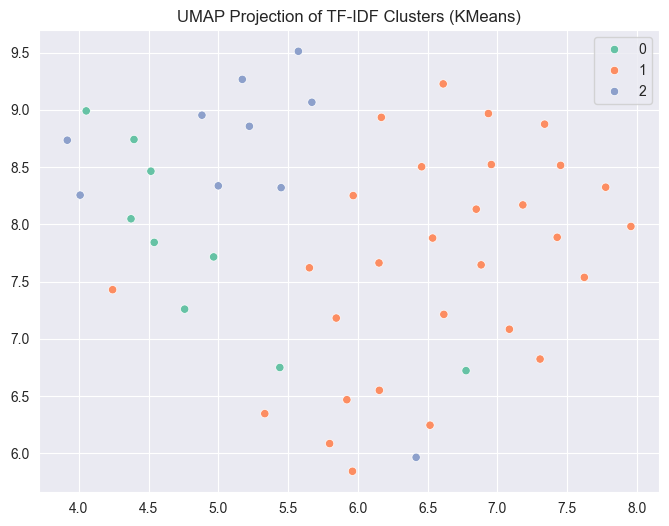

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(sequences_text)

kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

# UMAP Visualization of Clusters
umap_emb = umap.UMAP(random_state=42).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1], hue=kmeans_labels, palette="Set2")
plt.title("UMAP Projection of TF-IDF Clusters (KMeans)")
plt.show()


In [64]:

from sklearn.feature_extraction.text import TfidfVectorizer
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(sequences_text)

umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_tfidf.toarray())

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_tfidf.toarray())

kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

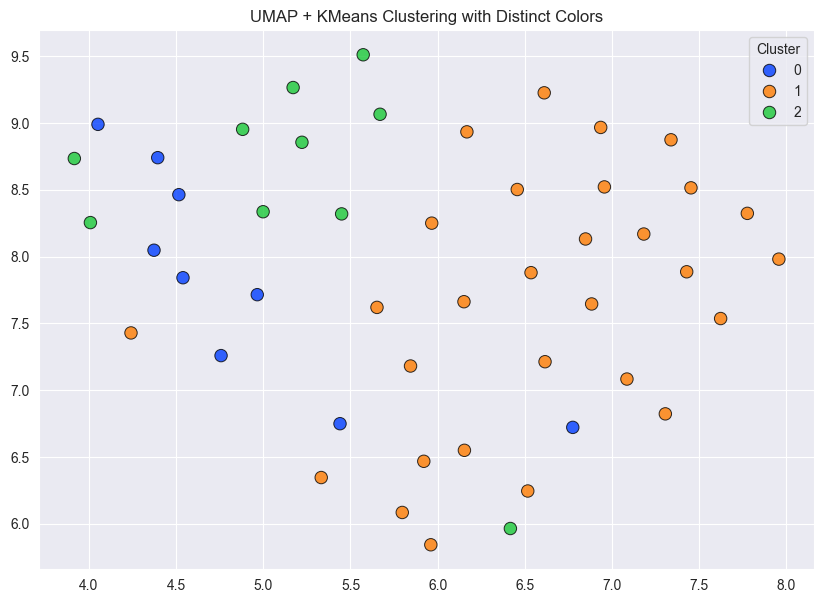

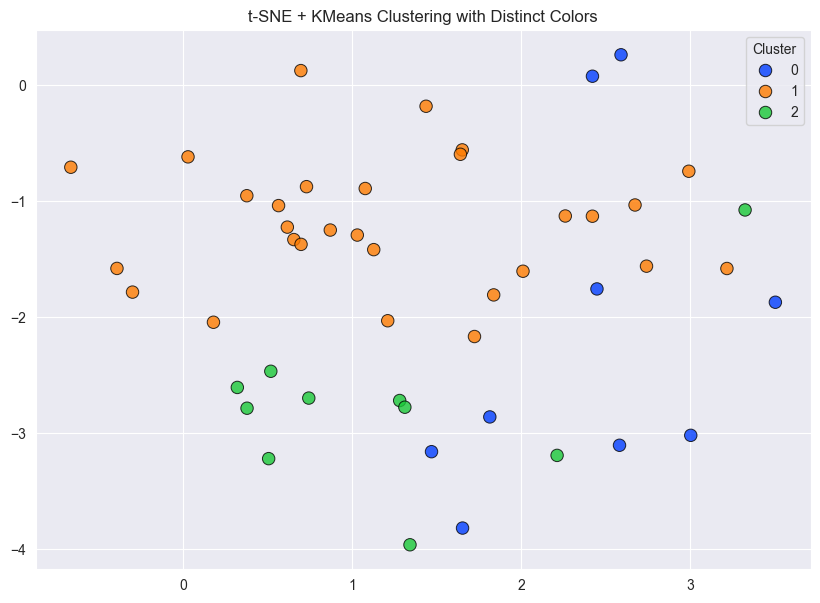

In [65]:

import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("bright", len(set(kmeans_labels)))

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=kmeans_labels, palette=palette, s=80, edgecolor='k', alpha=0.8)
plt.title("UMAP + KMeans Clustering with Distinct Colors")
plt.legend(title="Cluster", loc='best')
plt.show()

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette=palette, s=80, edgecolor='k', alpha=0.8)
plt.title("t-SNE + KMeans Clustering with Distinct Colors")
plt.legend(title="Cluster", loc='best')
plt.show()

In [66]:
def get_top_sequences(sequences, labels, cluster_id, top_n=5):
    cluster_seqs = [tuple(seq) for seq, label in zip(sequences, labels) if label == cluster_id]
    counter = Counter(cluster_seqs)
    return counter.most_common(top_n)


top_sequences_per_cluster = {}
for cluster_id in set(kmeans_labels):
    top_sequences = get_top_sequences(sequences, kmeans_labels, cluster_id, top_n=5)
    top_sequences_per_cluster[cluster_id] = top_sequences

for cluster_id, top_seqs in top_sequences_per_cluster.items():
    print(f"\nTop Sequences for Cluster {cluster_id}:")
    for seq, count in top_seqs:
        print(f"Count: {count} ➡️ Sequence: {seq}")



Top Sequences for Cluster 0:
Count: 1 ➡️ Sequence: ('AGE_GROUP:70s', 'GENDER:F', 'DX:99591 - Sepsis', 'DX:99662 - Infection and inflammatory reaction due to other vascular device, implant, and graft', 'DX:5672 - Unknown', 'DX:40391 - Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage V or end stage renal disease', 'DX:42731 - Atrial fibrillation', 'DX:4280 - Congestive heart failure, unspecified', 'DX:4241 - Aortic valve disorders', 'DX:4240 - Mitral valve disorders', 'DX:2874 - Unknown', 'DX:03819 - Other staphylococcal septicemia', 'DX:7850 - Tachycardia, unspecified', 'DX:E8791 - Kidney dialysis as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at time of procedure', 'DX:V090 - Infection with microorganisms resistant to penicillins', 'DX:56211 - Diverticulitis of colon (without mention of hemorrhage)', 'DX:28529 - Anemia of other chronic disease', 'DX:25000 - Diabetes mellitus without mention of 

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

sequences_text = [' '.join(seq) for seq in sequences]

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(sequences_text)

kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)


## 3️⃣ Exploratory Data Analysis (EDA)

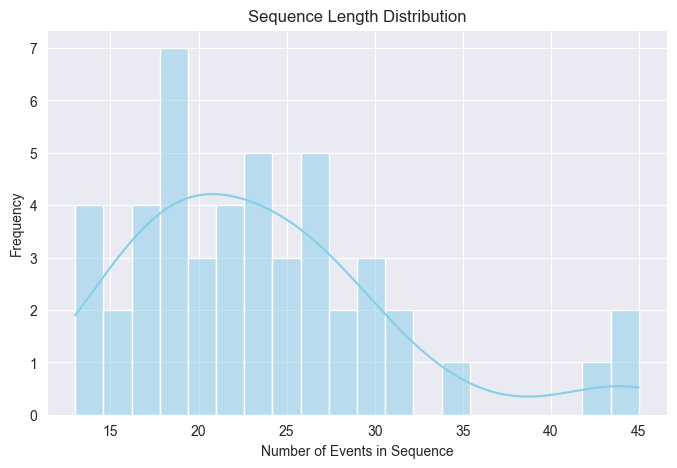

In [68]:

import matplotlib.pyplot as plt
import seaborn as sns

lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(8, 5))
sns.histplot(lengths, bins=20, kde=True, color="skyblue")
plt.title("Sequence Length Distribution")
plt.xlabel("Number of Events in Sequence")
plt.ylabel("Frequency")
plt.show()


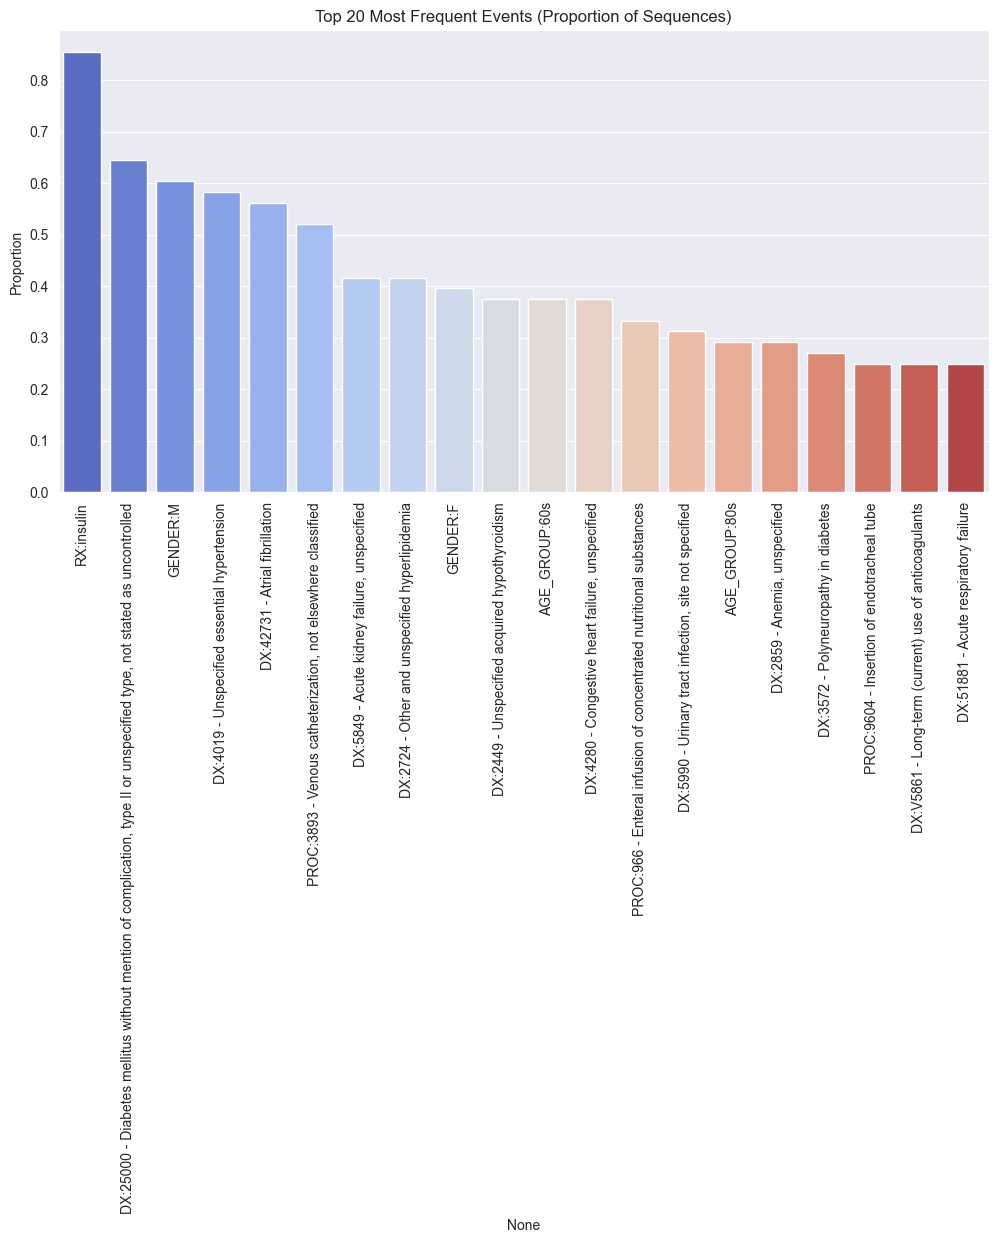

In [69]:

event_flat = [e for seq in sequences for e in seq]
event_series = pd.Series(event_flat)
top_events = event_series.value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_events.index, y=top_events.values / len(sequences), palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 20 Most Frequent Events (Proportion of Sequences)")
plt.ylabel("Proportion")
plt.show()


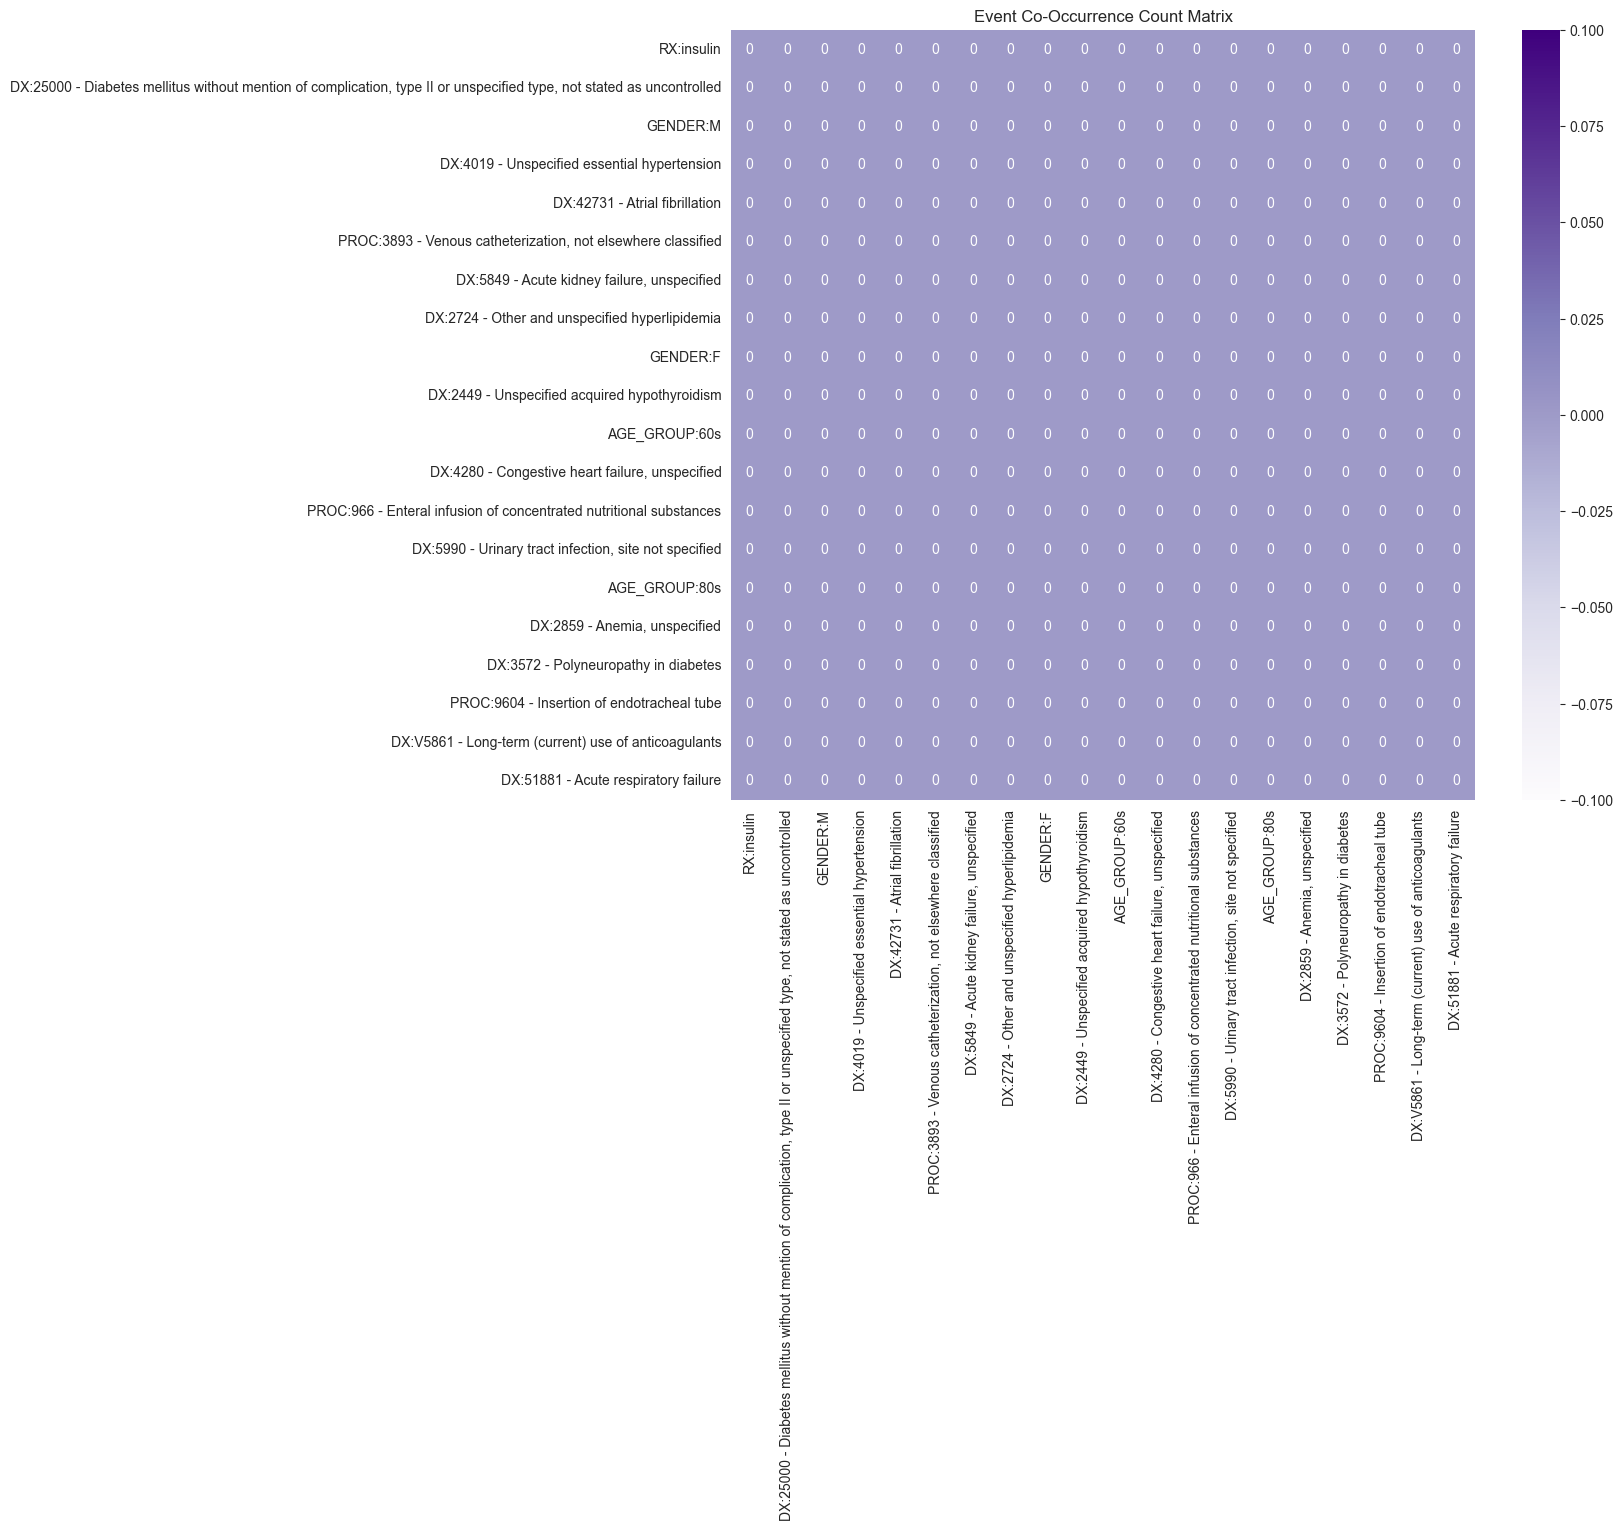

In [70]:

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

count_vectorizer = CountVectorizer(vocabulary=top_events.index)
X_counts = count_vectorizer.fit_transform(sequences_text)
df_counts = pd.DataFrame(X_counts.toarray(), columns=top_events.index)

co_occurrence = np.dot(df_counts.T, df_counts)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, xticklabels=top_events.index, yticklabels=top_events.index, cmap="Purples", annot=True,
            fmt='g')
plt.title("Event Co-Occurrence Count Matrix")
plt.show()


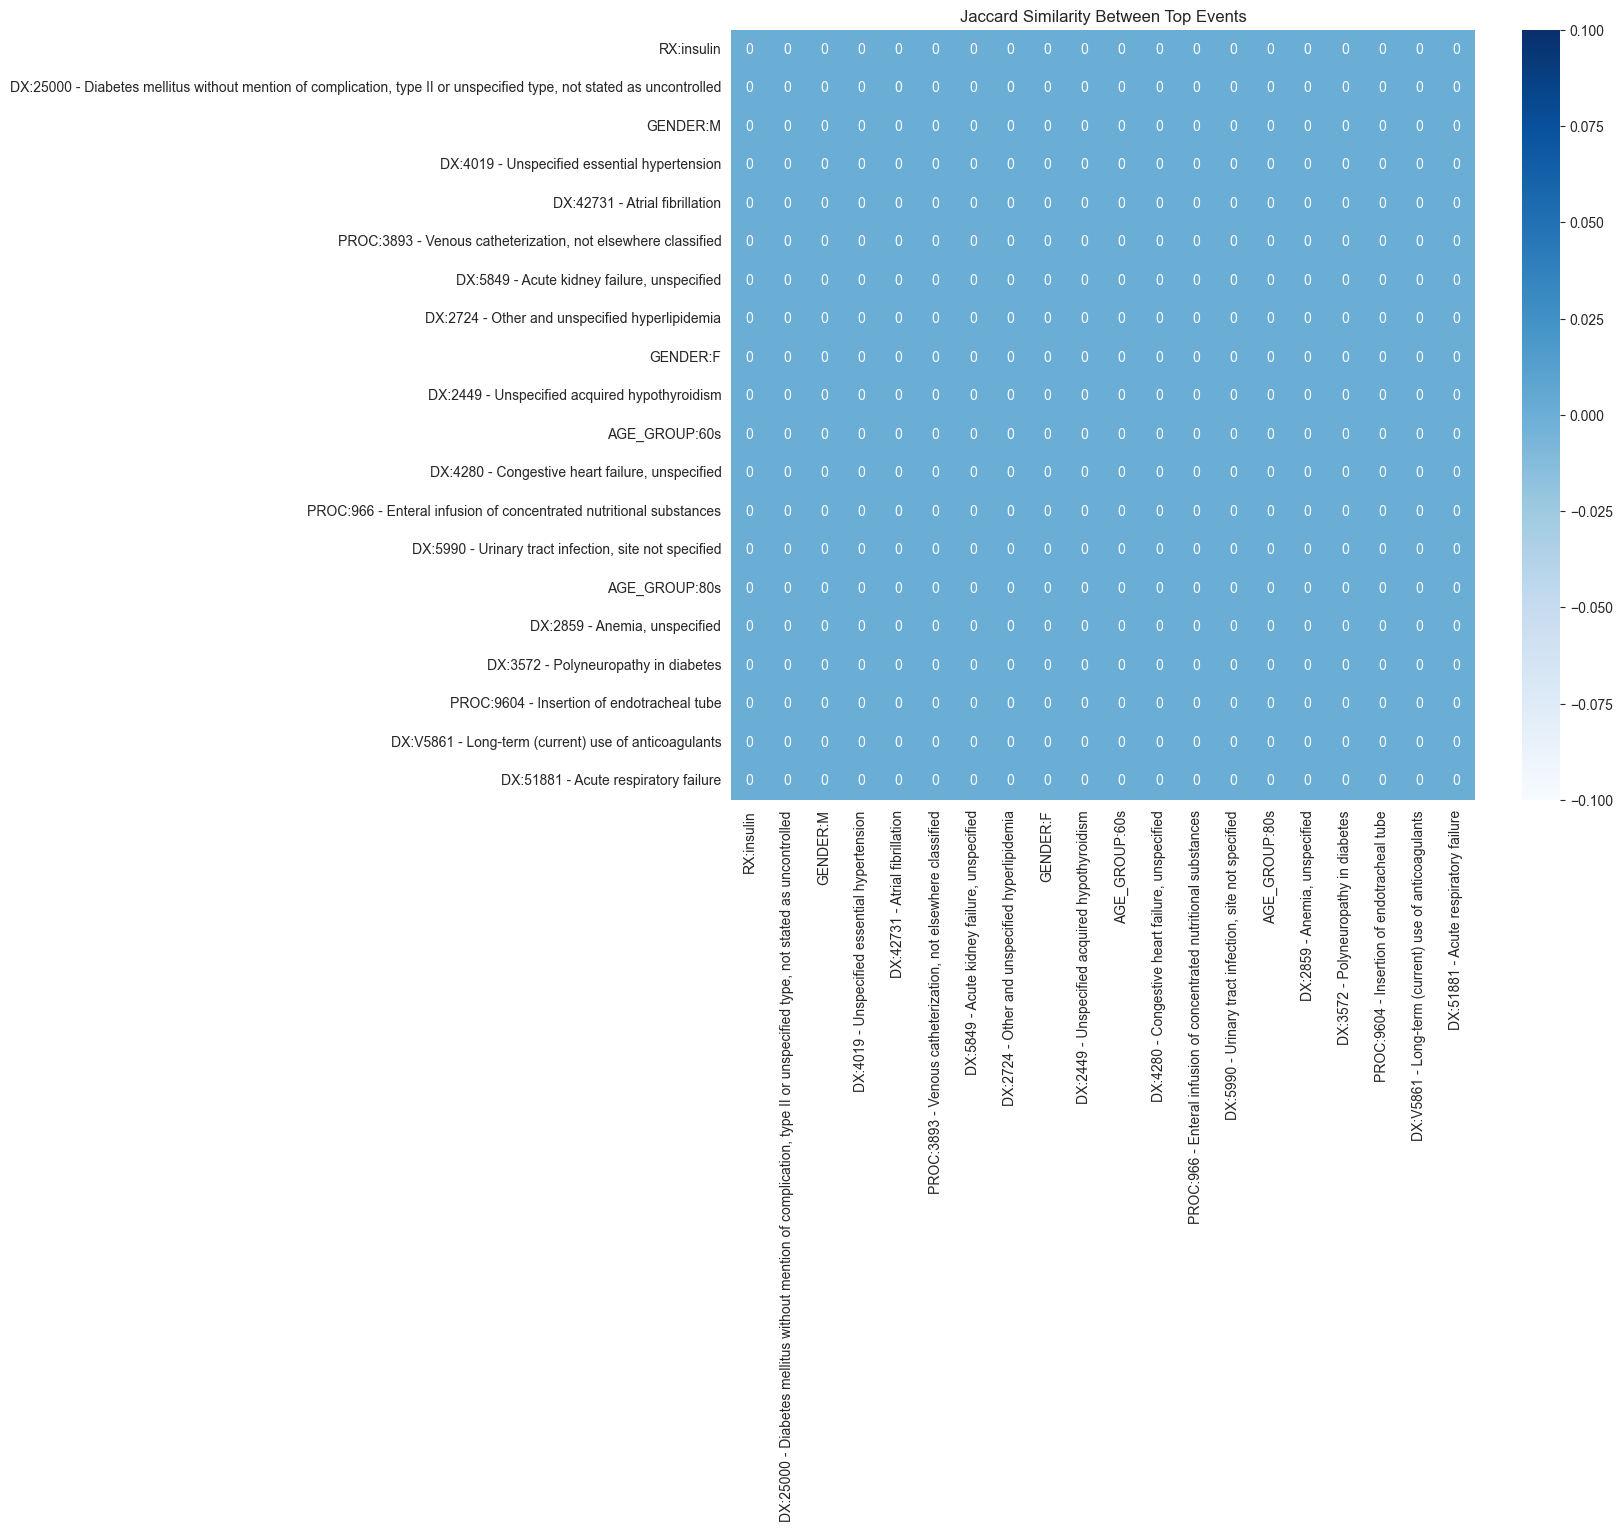

In [71]:

from sklearn.metrics import jaccard_score

jaccard_matrix = np.zeros((len(top_events), len(top_events)))

for i, event_i in enumerate(top_events.index):
    for j, event_j in enumerate(top_events.index):
        if i <= j:
            score = jaccard_score(df_counts[event_i], df_counts[event_j])
            jaccard_matrix[i, j] = score
            jaccard_matrix[j, i] = score

plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_matrix, xticklabels=top_events.index, yticklabels=top_events.index, cmap="Blues", annot=True)
plt.title("Jaccard Similarity Between Top Events")
plt.show()


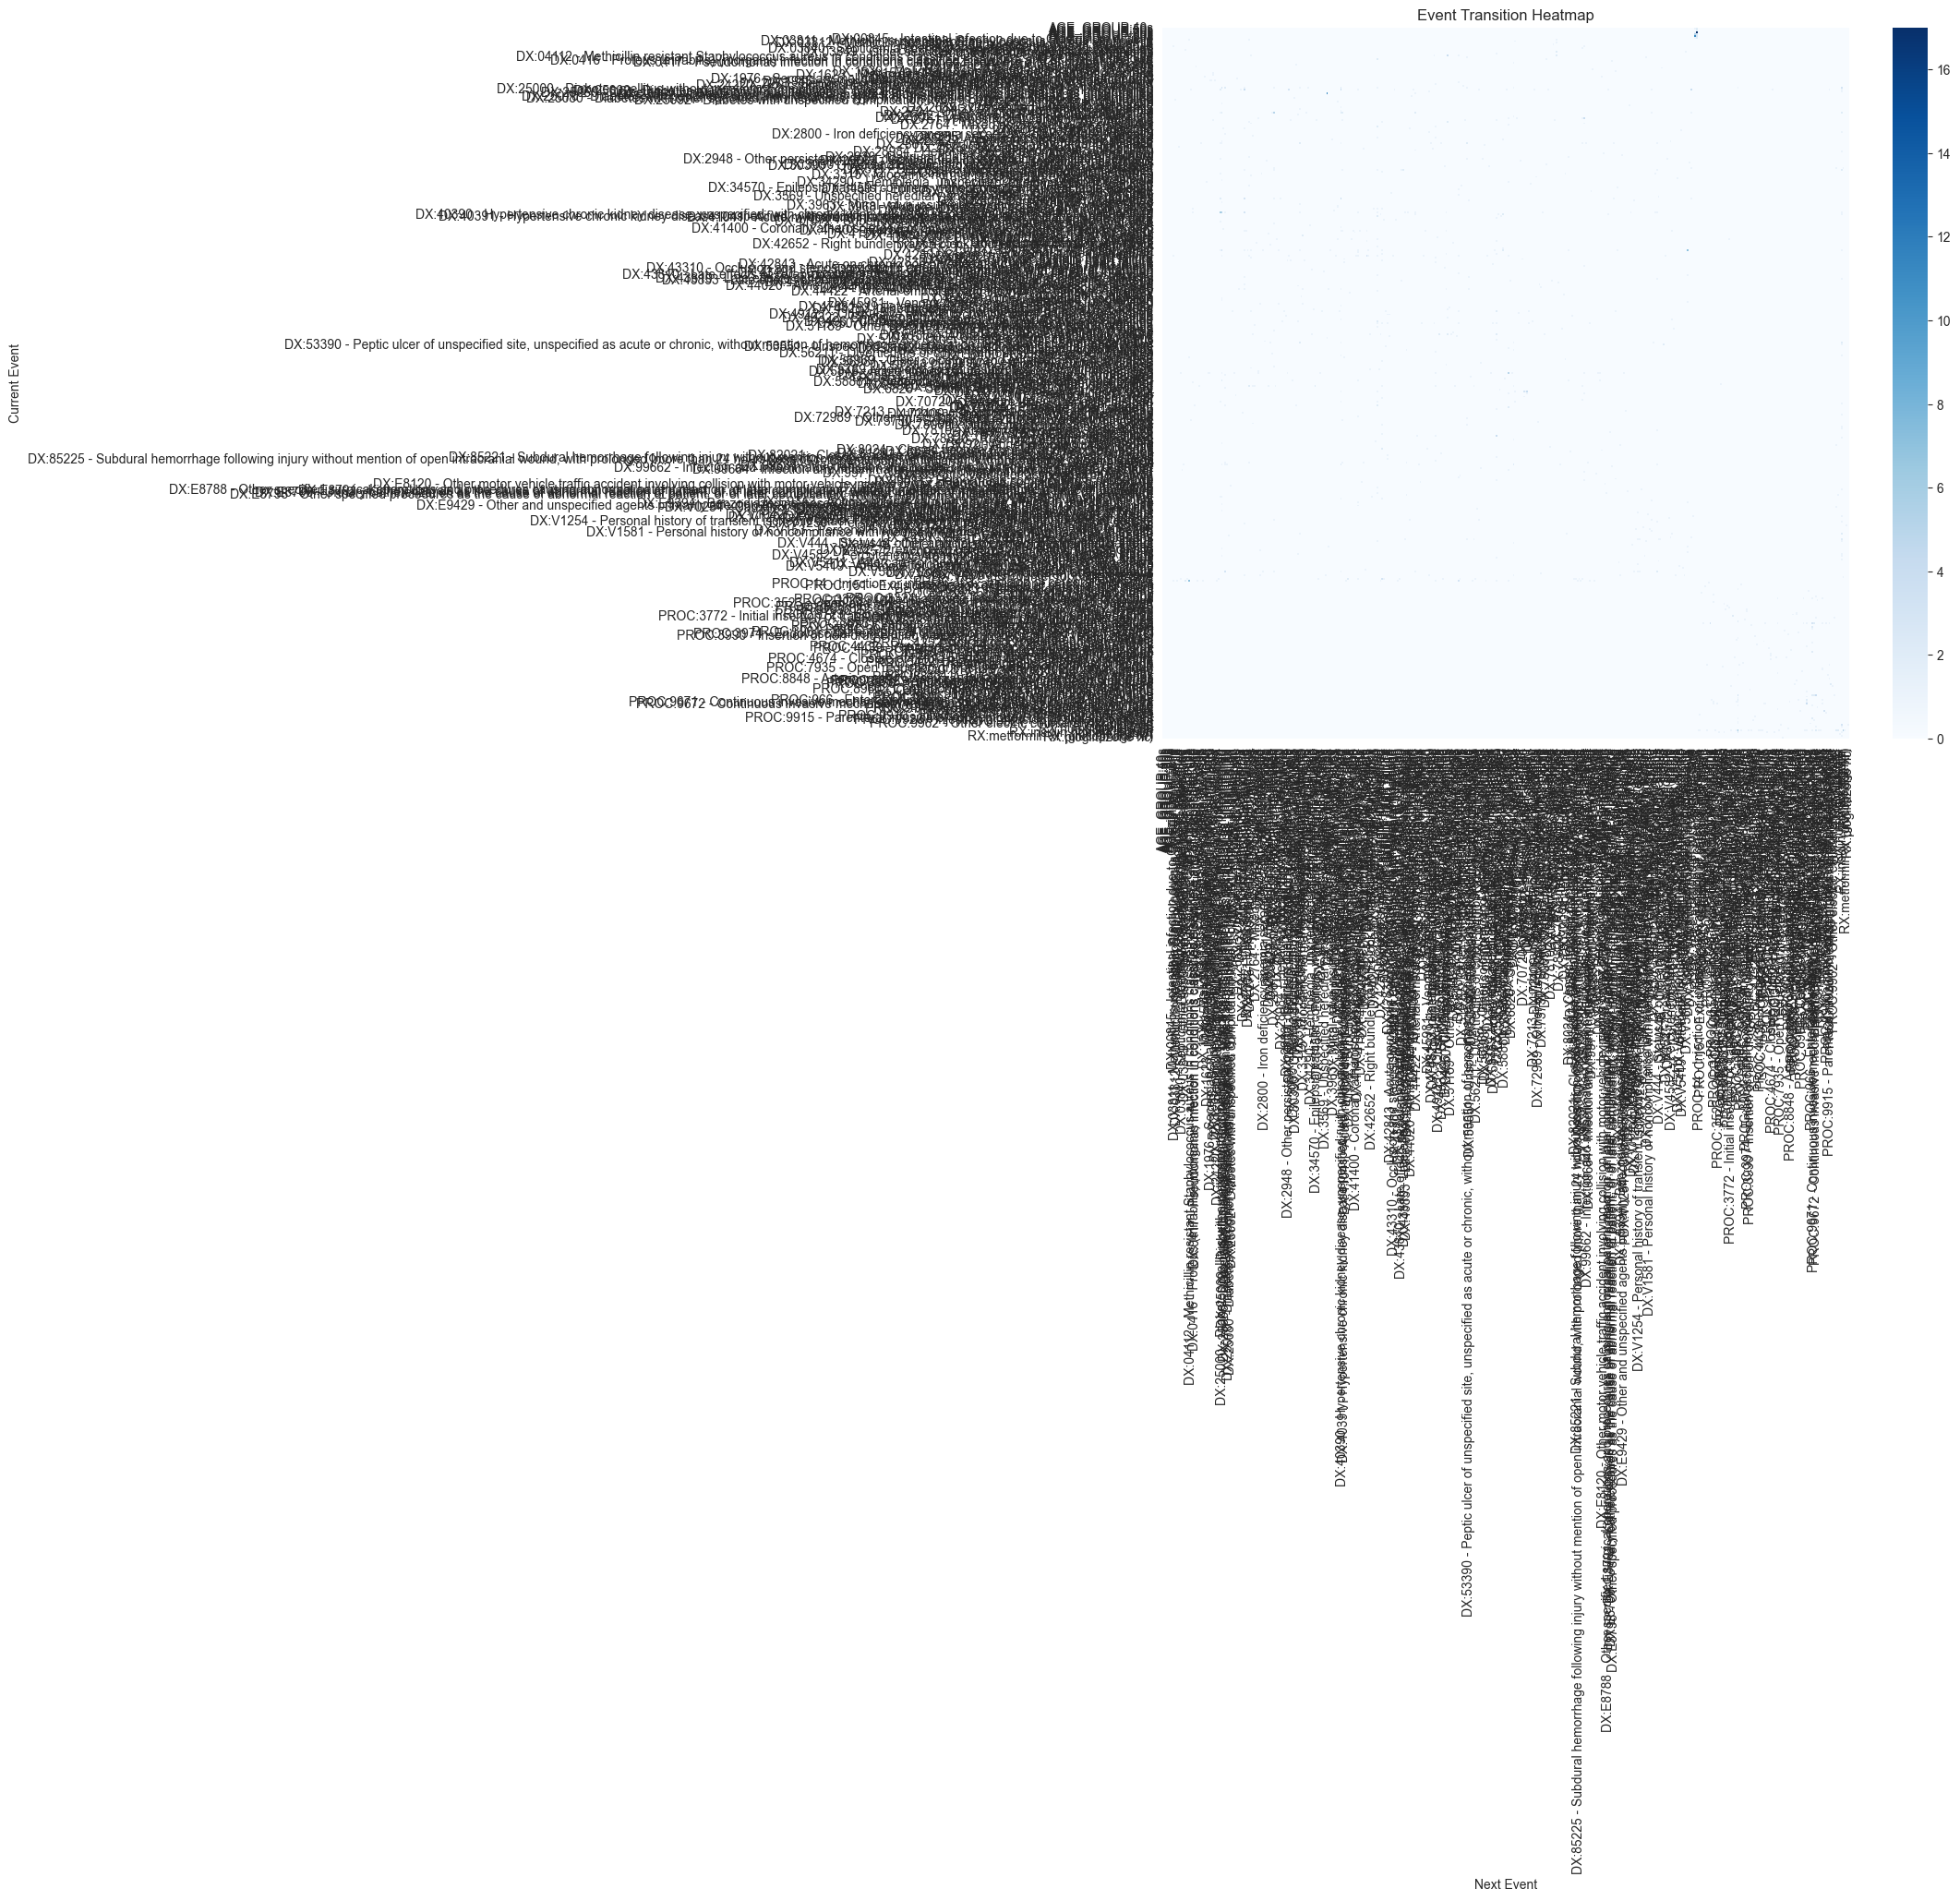

In [72]:

from collections import defaultdict
import numpy as np
import seaborn as sns

transitions = defaultdict(Counter)

for seq in sequences:
    for i in range(len(seq) - 1):
        transitions[seq[i]][seq[i + 1]] += 1

events = list(set(event for seq in sequences for event in seq))
events.sort()
matrix = np.zeros((len(events), len(events)))

for i, e1 in enumerate(events):
    for j, e2 in enumerate(events):
        matrix[i, j] = transitions[e1][e2]

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, xticklabels=events, yticklabels=events, cmap="Blues", annot=False, fmt="g")
plt.title("Event Transition Heatmap")
plt.xlabel("Next Event")
plt.ylabel("Current Event")
plt.show()


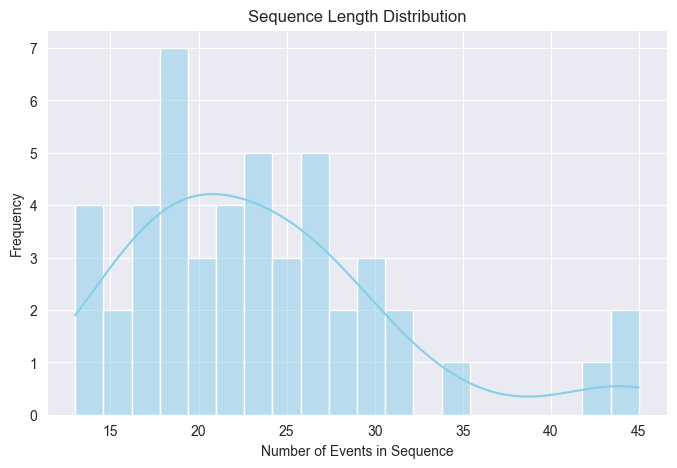

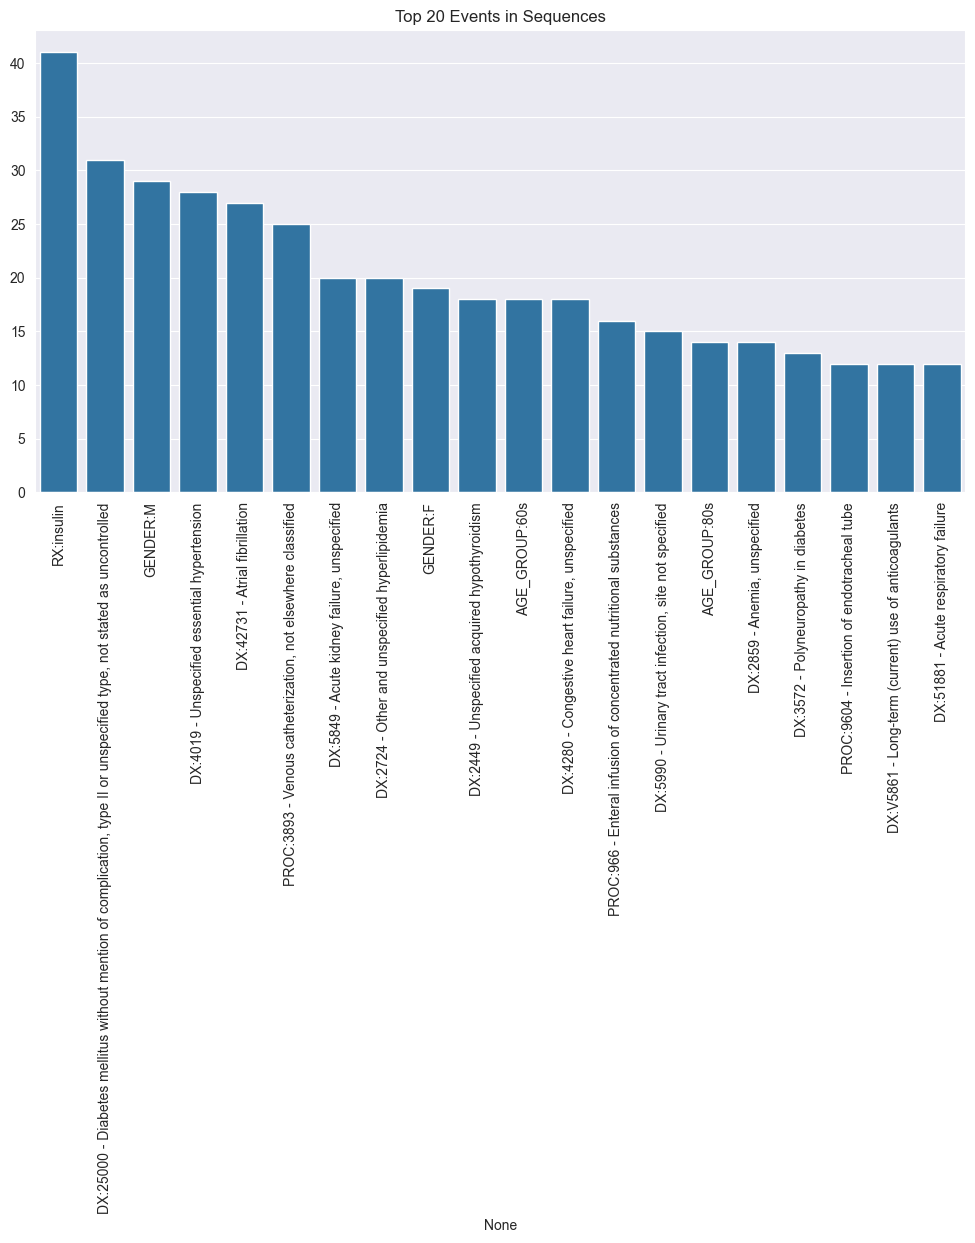

In [73]:

plt.figure(figsize=(8, 5))
lengths = [len(seq) for seq in sequences]
sns.histplot(lengths, bins=20, kde=True, color="skyblue")
plt.title("Sequence Length Distribution")
plt.xlabel("Number of Events in Sequence")
plt.ylabel("Frequency")
plt.show()

top_events = pd.Series(event_flat).value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_events.index, y=top_events.values)
plt.xticks(rotation=90)
plt.title("Top 20 Events in Sequences")
plt.show()


## 4️⃣ Process Mining & Graphs

In [74]:
import plotly.graph_objects as go

label_list = list(set([event for seq in sequences for event in seq]))
label_list.sort()
label_to_index = {label: idx for idx, label in enumerate(label_list)}

source = []
target = []

for seq in sequences:
    for i in range(len(seq) - 1):
        src = label_to_index[seq[i]]
        tgt = label_to_index[seq[i + 1]]
        source.append(src)
        target.append(tgt)

link_counts = Counter(zip(source, target))

K = 30
top_links = link_counts.most_common(K)

source, target, value = zip(*[(s, t, c) for (s, t), c in top_links])

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=label_list),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(
    title_text="Top 30 Transitions - Sankey Diagram of Event Sequences",
    font_size=12,
    width=1200,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()


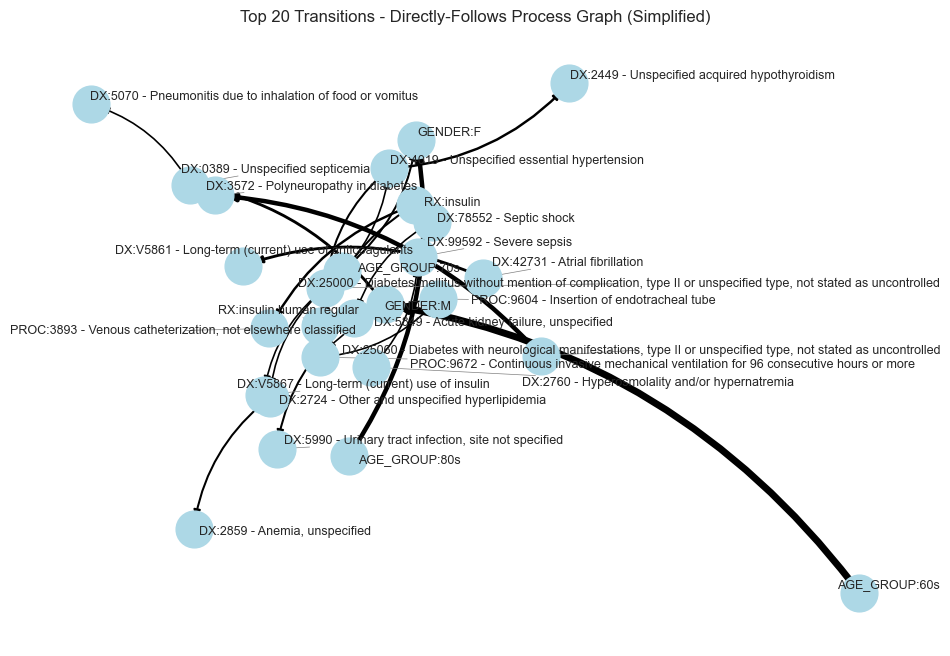

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

G_full = nx.DiGraph()

for seq in sequences:
    for i in range(len(seq) - 1):
        u, v = seq[i], seq[i + 1]
        if G_full.has_edge(u, v):
            G_full[u][v]['weight'] += 1
        else:
            G_full.add_edge(u, v, weight=1)

k = 20
all_edges = [(u, v, d['weight']) for u, v, d in G_full.edges(data=True)]
all_edges.sort(key=lambda x: x[2], reverse=True)
top_edges = all_edges[:k]

G = nx.DiGraph()
for u, v, w in top_edges:
    G.add_edge(u, v, weight=w)

plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_edges(G, pos, edgelist=edges, width=np.array(weights) / np.max(weights) * 5,
                       arrows=True, connectionstyle='arc3,rad=0.2')

texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title(f"Top {k} Transitions - Directly-Follows Process Graph (Simplified)")
plt.axis('off')
plt.show()


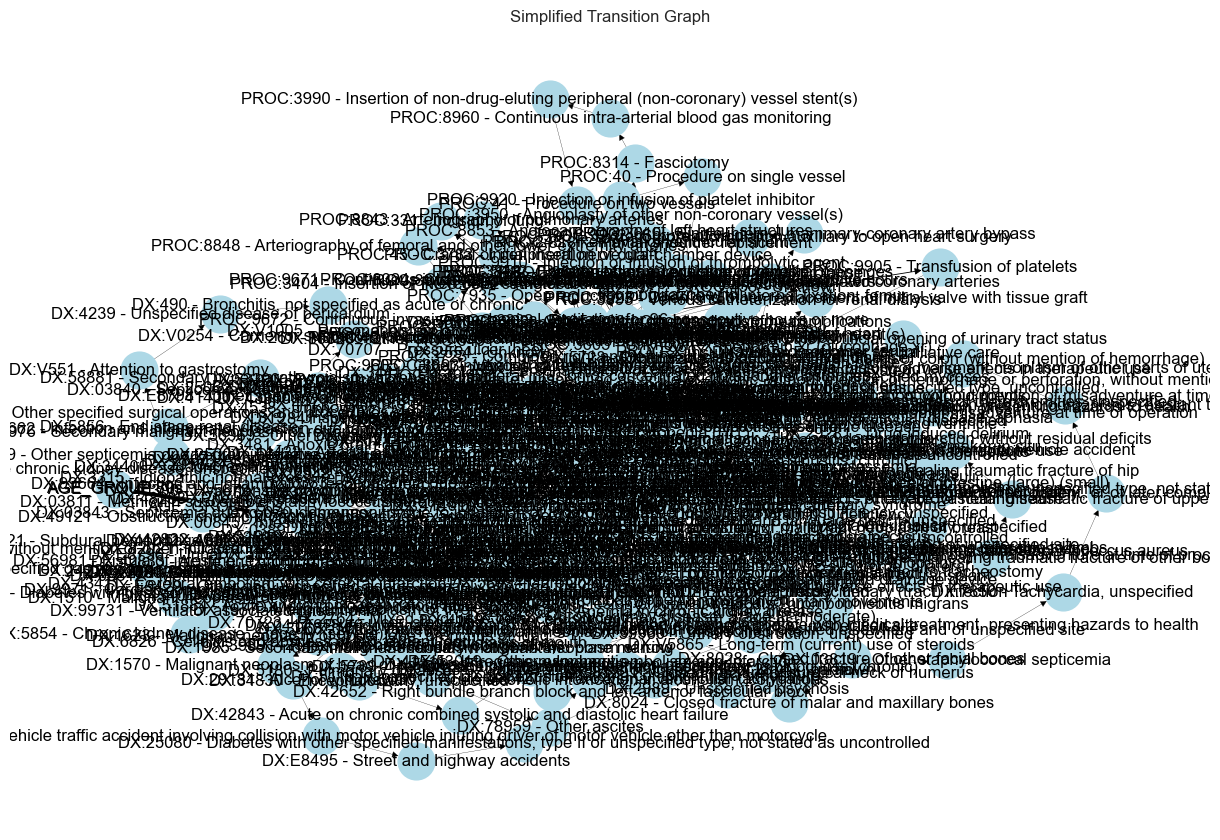

In [76]:
G = nx.DiGraph()
for seq in sequences:
    for i in range(len(seq) - 1):
        u, v = seq[i], seq[i + 1]
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700,
        width=[G[u][v]['weight'] / 5 for u, v in G.edges()])
plt.title("Simplified Transition Graph")
plt.show()


## 5️⃣ Prediction Models


RandomForest Evaluation:
AUC: 0.476
Average Precision: 0.792
F1 Score: 0.4
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.67      0.29      0.40         7

    accuracy                           0.40        10
   macro avg       0.48      0.48      0.40        10
weighted avg       0.55      0.40      0.40        10



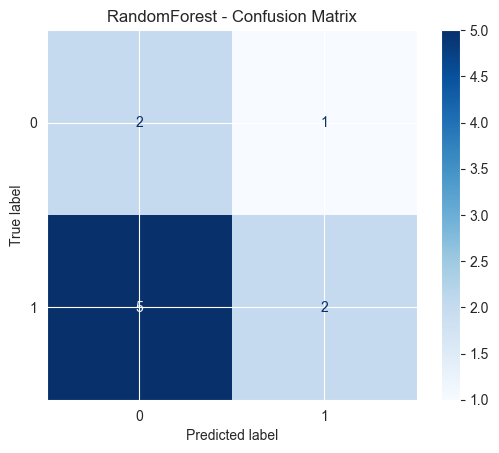

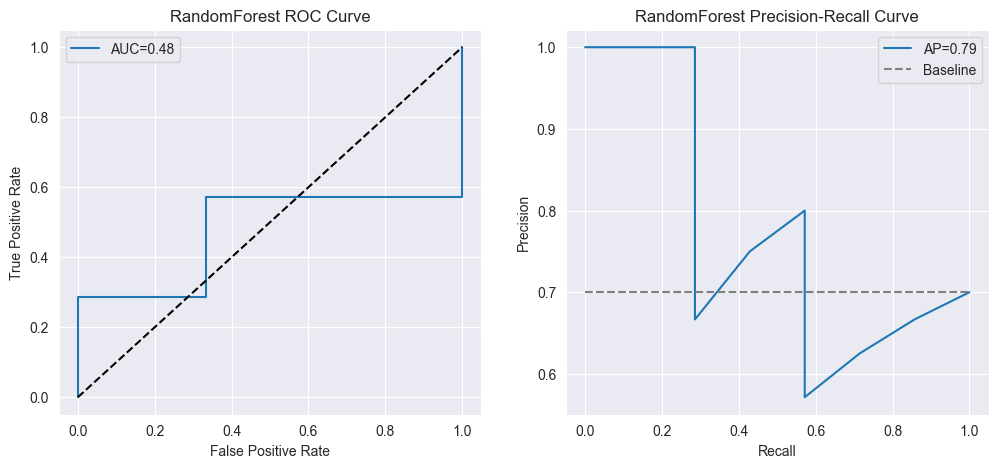


XGBoost Evaluation:
AUC: 0.5
Average Precision: 0.792
F1 Score: 0.667
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.80      0.57      0.67         7

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



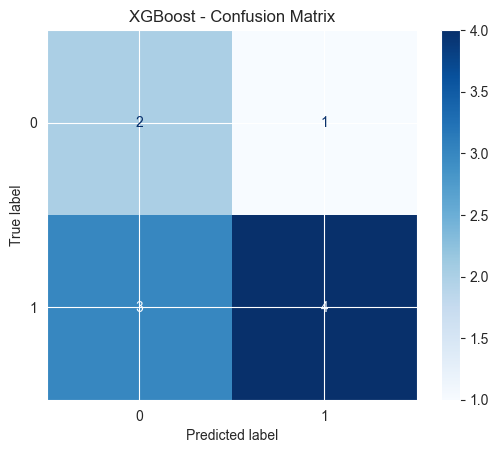

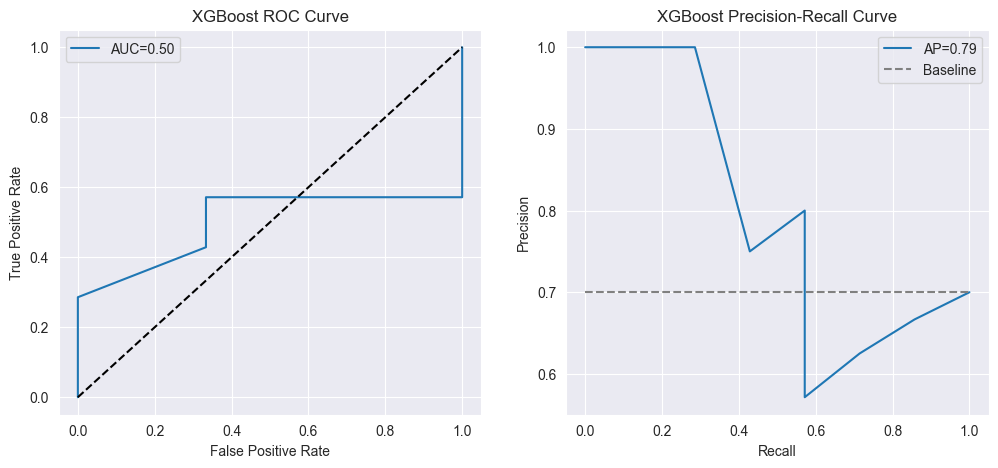


LogisticRegression Evaluation:
AUC: 0.238
Average Precision: 0.597
F1 Score: 0.364
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.50      0.29      0.36         7

    accuracy                           0.30        10
   macro avg       0.33      0.31      0.29        10
weighted avg       0.40      0.30      0.32        10



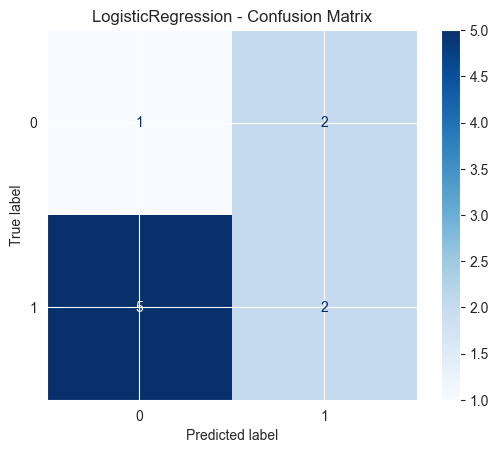

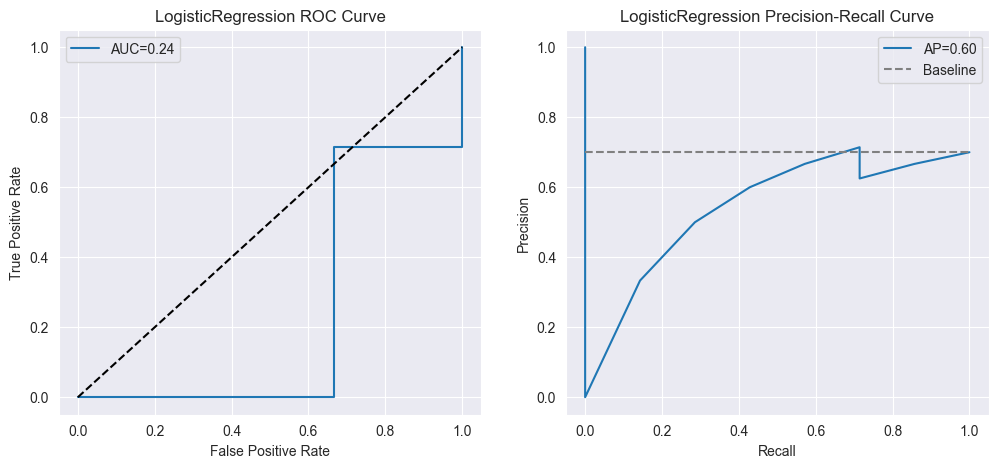

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score, f1_score
)
import matplotlib.pyplot as plt

assert len(sequence_vectors) <= len(labels_df), "Mismatch between sequences and labels"

labels_aligned = labels_df.iloc[:len(sequence_vectors)]

X_train, X_test, y_train, y_test = train_test_split(
    sequence_vectors,
    labels_aligned[['mortality', 'readmission']],
    test_size=0.2,
    random_state=42
)

models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=500)
}

for name, model in models.items():
    model.fit(X_train, y_train['mortality'])
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test['mortality'], probs)
    auc_score = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test['mortality'], probs)
    ap_score = average_precision_score(y_test['mortality'], probs)

    f1 = f1_score(y_test['mortality'], preds)

    cm = confusion_matrix(y_test['mortality'], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    print(f"\n{name} Evaluation:")
    print("AUC:", round(auc_score, 3))
    print("Average Precision:", round(ap_score, 3))
    print("F1 Score:", round(f1, 3))
    print("Classification Report:\n", classification_report(y_test['mortality'], preds))

    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name} ROC Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP={ap_score:.2f}')
    plt.hlines(y_test['mortality'].mean(), 0, 1, color='gray', linestyle='--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{name} Precision-Recall Curve")
    plt.legend()

    plt.show()


## 6️⃣ SHAP Explainability

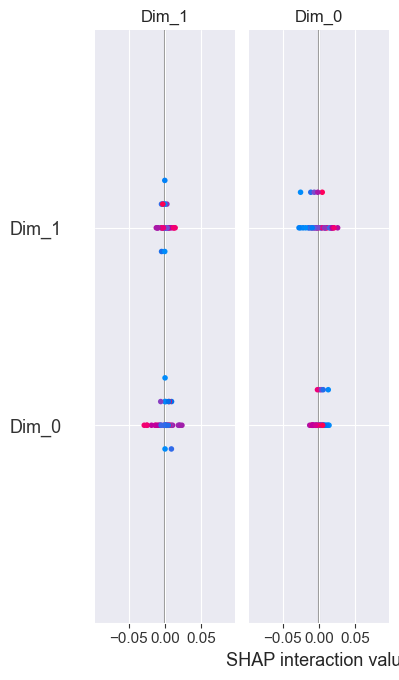

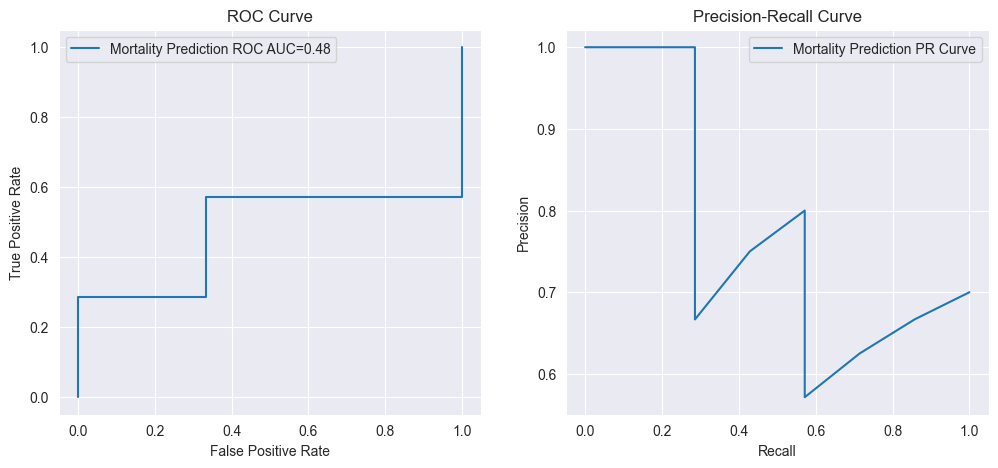

In [78]:
import shap

mort_model = models['RandomForest']
explainer = shap.Explainer(mort_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values.values, X_train, feature_names=[f"Dim_{i}" for i in range(X_train.shape[1])])


def plot_roc_pr(y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{label} ROC AUC={roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{label} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision-Recall Curve')
    plt.show()


mort_probs = mort_model.predict_proba(X_test)[:, 1]
plot_roc_pr(y_test['mortality'], mort_probs, 'Mortality Prediction')


## 8️⃣ Summary

In [79]:

summary = {
    "Total Sequences": len(sequences),
    "Average Sequence Length": np.mean([len(seq) for seq in sequences]),
    "Unique Events": len(set(event_flat)),
    "Most Common Event": Counter(event_flat).most_common(1)[0],
    "Least Common Event": Counter(event_flat).most_common()[-1]
}

for k, v in summary.items():
    print(f"{k}: {v}")


Total Sequences: 48
Average Sequence Length: 23.416666666666668
Unique Events: 398
Most Common Event: ('RX:insulin', 41)
Least Common Event: ('DX:72400 - Spinal stenosis, unspecified region', 1)


## 7️⃣ Cross-Validation & SMOTE (Improved Pipeline)

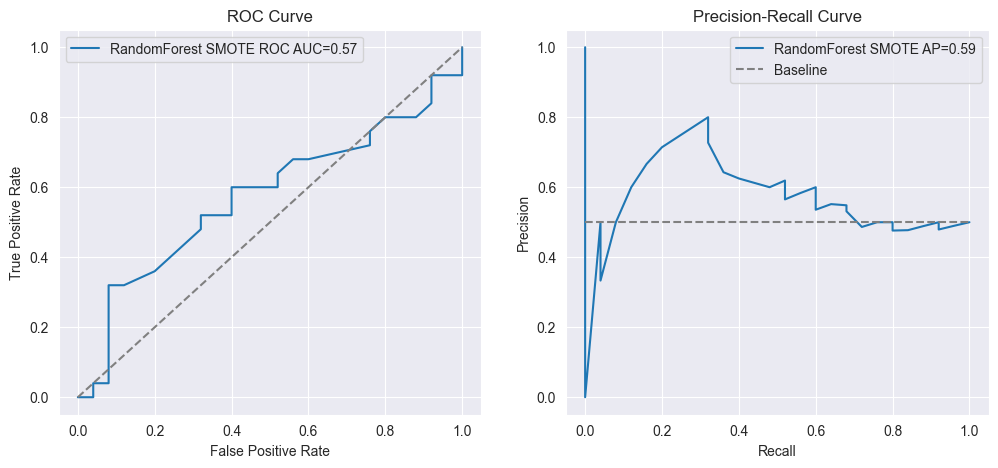

Cross-Validated AUC (mean): 0.584


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE

assert len(sequence_vectors) <= len(labels_df), "Mismatch between sequences and labels"
labels_aligned = labels_df.iloc[:len(sequence_vectors)]

sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(sequence_vectors, labels_aligned['mortality'])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

y_probs = cross_val_predict(rf, X_smote, y_smote, cv=cv, method='predict_proba')[:, 1]


def plot_roc_pr_improved(y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    ap = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{label} ROC AUC={roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.legend()
    plt.title('ROC Curve')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{label} AP={ap:.2f}')
    plt.hlines(np.mean(y_true), 0, 1, colors='gray', linestyles='--', label='Baseline')
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.legend()
    plt.title('Precision-Recall Curve')
    plt.show()


plot_roc_pr_improved(y_smote, y_probs, label='RandomForest SMOTE')

scores = cross_val_score(rf, X_smote, y_smote, cv=cv, scoring='roc_auc')
print("Cross-Validated AUC (mean):", round(np.mean(scores), 3))
